# SIRD parameter learning using FISTA with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1
from matplotlib.cm   import get_cmap

# Problem setup

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.01

## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$ as the three curves that satisfy the initial conditions.

In [5]:
T  = 10                           # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Parameters for the shape of R and S
aᵣ = 2.0;    bᵣ = 3;    cᵣ = 0.6
aₛ = 6;       bₛ = 0.001;    cₛ = 0.5

Rₜ  = 2 * arctan(aᵣ * (Tₑ - bᵣ)) / pi              # Weighted arctan
Rₜ  = (Rₜ - Rₜ[0])/(1 - Rₜ[0])                       # Normalised curve in [0, 1]
Rₜ *= cᵣ * n                                       # Limit recovered to cᵣ * n

Sₜ  = (exp(-bₛ * Tₑ**aₛ) + (1-cₛ))/(2.0 - cₛ)        # Normalised super gaussian in [cₛ/(2-cₛ),1]
Sₜ *= n * (1 - f)                                  # Proportion of susceptible at time 0: Sₒ 

In [7]:
Iₜ = n - Sₜ - Rₜ                                    # Infected is difference
if Iₜ.min() < 0:
    maximum(Iₜ, Iₜ[Iₜ > 0.0].min(), Iₜ);             # Ensure non negativity (might result in Sₜ + Iₜ + Rₜ > n)

In [8]:
print('Sₜ + Iₜ + Rₜ = n holds?', allclose(Sₜ + Iₜ + Rₜ, n))

Sₜ + Iₜ + Rₜ = n holds? True


Compute first derivative in time of desired state, just for interpolator:

In [9]:
dRₜ  = (2 * aᵣ) / ( pi * ( aᵣ**2 * (Tₑ - bᵣ)**2 + 1 ) )    # Weighted arctan
dRₜ /= 1 - Rₜ[0]                                            # Normalised curve in [0, 1]
dRₜ *= cᵣ * n                                              # Limit recovered to cᵣ * n

dSₜ  = -( aₛ * bₛ * (Tₑ)**(aₛ - 1.0) * exp(-bₛ * Tₑ**aₛ) )/(2.0 - cₛ)   # Normalised super gaussian in [cₛ/(2-cₛ),1]
dSₜ *= n * (1 - f)                                         # Proportion of susceptible at time 0: Sₒ 

In [10]:
dIₜ = 0.0 - dSₜ - dRₜ                                       # Infected is difference
if ((n - Sₜ - Rₜ) < 0).any():
    dIₜ[n - Sₜ - Rₜ <= 0.0] = 0.0                           # Use a subgradient (might require continuity argument)

Assemble state:

In [11]:
ρ̂  = asarray([Sₜ, Iₜ, Rₜ])
dρ̂ = asarray([dSₜ, dIₜ, dRₜ])

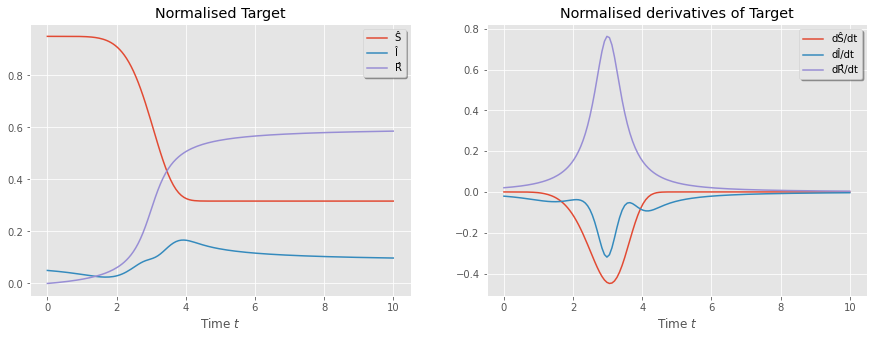

In [12]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, dρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dŜ/dt', 'dÎ/dt', 'dR̂/dt'], shadow=True)
plt.title('Normalised derivatives of Target')
plt.show()

In [13]:
# Give a random initial control
α = asarray([0.01,0.02])

In [14]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [15]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)

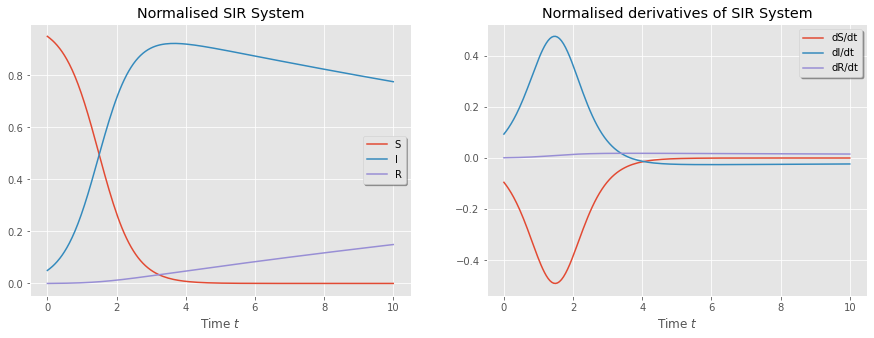

In [16]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [17]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [18]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 416 function evaluations.


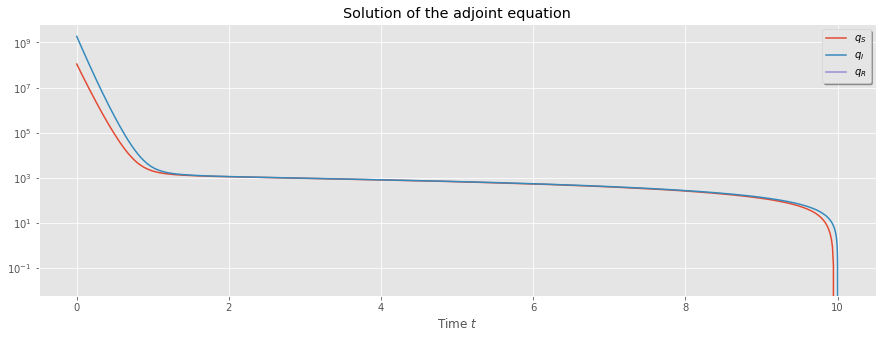

In [19]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 ).
\end{align}

In [20]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum())

In [21]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [22]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+20) ))

As an example, the distance between ρ and ρ̂ is 25000000000152464.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
\end{align}

In [23]:
q = solₛ.y[:,::-1]

In [24]:
θ = 0.1
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ) + θ * α[0], simpson(ρ[1] * (q[2]-q[1]), Tₑ) + θ * α[1]])
display(df.tolist())

[207386783321.35318, -1181698193.521111]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [25]:
θ = 0.0

In [26]:
def obj_eval_a(α):                # ** Eval just f ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

In [27]:
# Coarse evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.00,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a( asarray([β,γ]) ).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [28]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 1.8269310740815836; (β,γ): 0.02 0.314


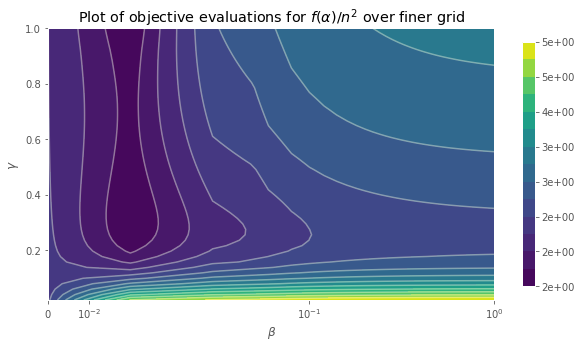

In [29]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('symlog', linthresh = 5e-2)
#plt.xscale('log')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \omega_0 \in [0,1]^2$, $\theta_0 = 1$, $L_0>0$, $\eta > 1$, and $a < 1$.</li>
<li>
    For any $L>0$ and $\alpha,\omega \in [0,1]^2$, define the functions
    \begin{align}
        p_L (\omega) &= \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ],
    \\
        q_L (\omega,\alpha) &= f(\alpha) + \langle \omega-\alpha, \nabla f(\alpha) \rangle + \frac{L}{2} \|\omega-\alpha\|^2.
    \end{align}
</li>
    
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\omega_k}$
<li>Compute adjoint $q_{\omega_k}$
<li>Evaluate the gradient of the reduced functional $ \nabla f(\omega_k)$

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    f\big( p_L (\omega_k) \big) &\leq q_L \big( p_L(\omega_k), \omega_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $\alpha_{k+1} = p_{L_{k+1}} (\omega_k)$
<li>Update $\theta_{k+1} = a k + 1$
<li>Update $\omega_{k+1} = \alpha_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (\alpha_{k+1} - \alpha_k)$
</li>
</ol>
</div>

Let's select a initial point at random:

In [30]:
β, γ = α = rng(0).uniform(0,1,2)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [31]:
def FISTA(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-16, try_TR = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'df_β':[], 'df_γ':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    # Initialisation
    # 1.1, 0.965, 10, 11/5   [0.259914]
    # 1.01, 0.965, 10, 11/5  [0.107911]
    # Best so far
    # 1.01 0.1 10 11/5 [0.100978]
    
    ω = α.copy()
    θₖ = 1.0      # Inertia parameter (not to be confused with \theta)
    η = 1.01     # Scaling for backtracking
    L = 2.0#0.965     # Approximation of the Lipschitz constant
    I = 10       # Number of iterations for backtracking
    a = 11.0/5   # Inertia weight (a > 2)
    
    # First objective evaluation
    # Compute state and adjoint for ω
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ)/(n**2)
    
    timed = 0.0
    for k in range(iters):
        #print(L)
        α_o = α.copy()
        θ_o = θₖ
        f_o = f
        
        it_time = time.time()
        
        # Compute state and adjoint for ω
        ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=ω, t_eval = Tₑ, 
                          dense_output=True, vectorized=True)
        if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
        ρ = ρ_sol.y
        f = Objective(ρ,ρ̂,ω,θ) / (n**2)
        ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,ω[0],ω[1])), axis=-1)        # Interpolate state 
        
        # Compute adjoint
        q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(ω[0], ω[1], ρₜ), t_eval = Tₑ[::-1], 
                          dense_output=True, vectorized=True)
        q = q_sol.y[:,::-1]
        
        # Compute derivative
        df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
        df += (θ * ω)
        df /= (n**2)   # scaling
        
        # Store info for initial point
        if k == 0 and save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        
        # Create scale factor is derivative is too far away from [0,1]^2:
        #s  = 1.0/norm(df) if norm(df,np.inf) > 1.1 else 1.0
        s  = 0.1/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        
        # Backtracking
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L
            b  = 1.0/Lₓ
            # Gradient and proximal step
            u = ω - (b * s) * df
            p = proj(u)
            # Compute state to validate Lₓ
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=p, t_eval = Tₑ, dense_output=True, vectorized=True)
            fₖ = Objective(ρ_sol.y,ρ̂,p,θ)/(n**2)
            # Validation step
            if fₖ <= f + (p - ω).dot(df) + 0.5 * (Lₓ/s) * norm(p - ω)**2:
                break
        
        # Update control
        L = Lₓ
        α = p.copy()
        # Update inertia
        θₖ = ((k+1)/a) + 1.0
        ω = α + (θ_o - 1) * ( α - α_o )/θₖ
        if (ω < 0.0).any():
            #print('hey', ω)
            # Infeasible point is projected back into the box
            ω = proj(ω)
        
        Exit = True
        '''if L > 1e+4:
            print('Here')
            θₖ = (a/(k+1))
            η = 1.01     # Scaling for backtracking
            L = 0.965     # Approximation of the Lipschitz constant
            I = 20       # Number of iterations for backtracking
            a = 11.0/5   # Inertia weight (a > 2)
            #α = α_o.copy()
            α = ω.copy()
            Exit = False'''
            #break
        
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(2**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f, timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
        
        if abs(f - f_o) < εᵦ and k > 10:
            print('|f-fₖ| < {0:1.0e}'.format(εᵦ))
            break
        
        if norm(α - α_o)/(2.0**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    return α, ρ, every_critical, every_iter

In [32]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [34]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    #ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, θ, 10000, save_iter = True, critical = 10, ε = 1e-20)
    ᾱ, ρ, every_critical, every_iter = FISTA(α, 10000, save_iter = True, 
                                             critical = 100, εₐ = 1e-7, εᵦ = 1e-10,try_TR = False)


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)
    
    
    # Store info from iterate with smallest objective
    ArgMin_FISTA = df_every.idxmin()['obj']
    Out_θ = df_every.loc[[ArgMin_FISTA]].rename(index={ArgMin_FISTA:θ}).copy()
    
    # Recover state with smallest objective
    sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=(Out_θ['β'].values.item(), Out_θ['γ'].values.item()), 
                t_eval = Tₑ, dense_output=True, vectorized=True)
    
    ρ = sol.y
    #df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6e+00 |     0.22  | 2.538e-01   |   3.572e-01  
*    100 |  3.3e-01 |     2.38  | 1.336e+02   |   1.890e+02  
*    200 |  8.7e-02 |     3.02  | 1.552e+01   |   2.194e+01  
*    300 |  9.4e-02 |     3.52  | 4.059e+01   |   5.740e+01  
*    400 |  8.5e-02 |     3.91  | 8.538e+00   |   1.207e+01  
*    500 |  8.5e-02 |     4.32  | 3.812e+00   |   5.390e+00  
*    600 |  8.5e-02 |     4.80  | 2.992e+00   |   4.231e+00  
*    700 |  8.6e-02 |     5.22  | 1.571e+01   |   2.222e+01  
*    800 |  8.5e-02 |     5.61  | 7.994e+00   |   1.131e+01  
*    900 |  8.5e-02 |     6.00  | 7.771e+00   |   1.099e+01  
*   1000 |  8.5e-02 |     6.38  | 8.590e+00   |   1.215e+01  
*   1100 |  8.7e-02 |     6.77  | 1.732e+01   |   2.449e+01  
*   1200 |  8.6e-02 |     7.19  | 1.180e+01   |   1.669e+01  
*   1300 |  8.5e-0

*   4200 |  8.9e-02 |    19.78  | 8.297e-02   |   9.943e-02  
*   4300 |  8.9e-02 |    20.20  | 4.487e-02   |   6.342e-02  
*   4400 |  8.9e-02 |    21.27  | 7.793e-02   |   8.952e-02  
*   4500 |  8.9e-02 |    21.90  | 2.134e-01   |   2.949e-01  
*   4600 |  8.9e-02 |    22.55  | 2.208e-01   |   3.055e-01  
*   4700 |  8.8e-02 |    23.25  | 2.899e-01   |   4.048e-01  
*   4800 |  8.8e-02 |    23.71  | 3.309e-01   |   4.633e-01  
*   4900 |  8.8e-02 |    24.12  | 4.395e-01   |   6.181e-01  
*   5000 |  8.8e-02 |    24.58  | 5.402e-01   |   7.612e-01  
*   5100 |  8.8e-02 |    25.04  | 5.709e-01   |   8.048e-01  
*   5200 |  8.8e-02 |    25.50  | 6.156e-01   |   8.681e-01  
*   5300 |  8.8e-02 |    25.96  | 6.668e-01   |   9.408e-01  
*   5400 |  8.8e-02 |    26.41  | 6.695e-01   |   9.445e-01  
*   5500 |  8.8e-02 |    26.85  | 7.464e-01   |   1.053e+00  
*   5600 |  8.8e-02 |    27.29  | 7.918e-01   |   1.118e+00  
*   5700 |  8.8e-02 |    27.74  | 7.962e-01   |   1.124e+00  
*   5800

*   7100 |  8.8e-02 |    31.75  | 2.663e+00   |   3.765e+00  
*   7200 |  8.8e-02 |    32.16  | 2.648e+00   |   3.744e+00  
*   7300 |  8.8e-02 |    32.62  | 2.649e+00   |   3.746e+00  
*   7400 |  8.8e-02 |    33.05  | 2.649e+00   |   3.746e+00  
*   7500 |  8.8e-02 |    33.48  | 2.648e+00   |   3.745e+00  
*   7600 |  8.8e-02 |    33.91  | 2.646e+00   |   3.741e+00  
*   7700 |  8.8e-02 |    34.34  | 2.646e+00   |   3.742e+00  
*   7800 |  8.8e-02 |    34.75  | 2.643e+00   |   3.737e+00  
*   7900 |  8.8e-02 |    35.18  | 2.628e+00   |   3.716e+00  
*   8000 |  8.8e-02 |    35.63  | 2.620e+00   |   3.705e+00  
‖αₖ - p‖ < 1e-07
[0.0072047  0.79022753]

Algorithm stopped after 35.8760 seconds and 8061 iterations
–––––––––––––––––––– 1e-04 –––––––––––––––––––– 


     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6e+00 |     0.21  | 2.538e-01   |   3.572e-01  
*    100 |  1.1e-01 |     2.51  | 2.933e

*   5600 |  1.3e-01 |    23.15  | 5.746e+01   |   8.126e+01  
*   5700 |  1.3e-01 |    23.51  | 5.755e+01   |   8.139e+01  
*   5800 |  1.3e-01 |    23.85  | 5.750e+01   |   8.132e+01  
*   5900 |  1.3e-01 |    24.21  | 5.734e+01   |   8.109e+01  
*   6000 |  1.3e-01 |    24.57  | 5.702e+01   |   8.064e+01  
*   6100 |  1.3e-01 |    24.93  | 5.655e+01   |   7.998e+01  
*   6200 |  1.3e-01 |    25.29  | 5.595e+01   |   7.913e+01  
*   6300 |  1.3e-01 |    25.63  | 5.522e+01   |   7.810e+01  
*   6400 |  1.3e-01 |    25.97  | 5.440e+01   |   7.693e+01  
*   6500 |  1.3e-01 |    26.31  | 5.358e+01   |   7.577e+01  
*   6600 |  1.3e-01 |    26.65  | 5.278e+01   |   7.464e+01  
*   6700 |  1.2e-01 |    26.99  | 5.146e+01   |   7.277e+01  
*   6800 |  1.2e-01 |    27.33  | 5.030e+01   |   7.113e+01  
*   6900 |  1.2e-01 |    27.67  | 4.913e+01   |   6.947e+01  
*   7000 |  1.2e-01 |    28.02  | 4.776e+01   |   6.754e+01  
*   7100 |  1.2e-01 |    28.37  | 4.641e+01   |   6.564e+01  
*   7200

*   8500 |  8.6e-02 |    36.55  | 2.024e+00   |   2.862e+00  
*   8600 |  8.6e-02 |    36.94  | 2.017e+00   |   2.852e+00  
*   8700 |  8.6e-02 |    37.34  | 2.005e+00   |   2.835e+00  
*   8800 |  8.6e-02 |    37.74  | 1.994e+00   |   2.820e+00  
*   8900 |  8.6e-02 |    38.14  | 1.983e+00   |   2.803e+00  
*   9000 |  8.6e-02 |    38.54  | 1.979e+00   |   2.799e+00  
*   9100 |  8.6e-02 |    38.94  | 1.971e+00   |   2.787e+00  
*   9200 |  8.6e-02 |    39.35  | 1.956e+00   |   2.765e+00  
*   9300 |  8.6e-02 |    39.75  | 1.930e+00   |   2.729e+00  
*   9400 |  8.6e-02 |    40.16  | 1.924e+00   |   2.721e+00  
*   9500 |  8.6e-02 |    40.57  | 1.913e+00   |   2.704e+00  
*   9600 |  8.6e-02 |    40.95  | 1.914e+00   |   2.706e+00  
*   9700 |  8.6e-02 |    41.31  | 1.904e+00   |   2.692e+00  
*   9800 |  8.6e-02 |    41.68  | 1.891e+00   |   2.673e+00  
*   9900 |  8.6e-02 |    42.03  | 1.880e+00   |   2.658e+00  

Algorithm stopped after 42.3893 seconds and 9999 iterations
–––––––––

*   1000 |  9.1e-02 |     6.31  | 5.991e-02   |   8.441e-02  
*   1100 |  9.1e-02 |     6.74  | 5.678e-02   |   8.015e-02  
*   1200 |  9.0e-02 |     7.45  | 1.069e-01   |   1.297e-01  
*   1300 |  9.0e-02 |     8.51  | 5.868e-02   |   7.324e-02  
*   1400 |  8.9e-02 |     9.02  | 6.086e-02   |   7.051e-02  
*   1500 |  8.9e-02 |     9.39  | 1.749e-01   |   2.375e-01  
*   1600 |  8.9e-02 |     9.77  | 2.025e-01   |   2.785e-01  
*   1700 |  8.9e-02 |    10.15  | 2.423e-01   |   3.364e-01  
*   1800 |  8.9e-02 |    10.54  | 2.648e-01   |   3.691e-01  
*   1900 |  8.9e-02 |    10.94  | 3.678e-01   |   5.164e-01  
*   2000 |  8.9e-02 |    11.34  | 3.255e-01   |   4.562e-01  
*   2100 |  8.9e-02 |    11.75  | 3.617e-01   |   5.078e-01  
*   2200 |  8.9e-02 |    12.13  | 3.642e-01   |   5.116e-01  
*   2300 |  8.9e-02 |    12.54  | 3.939e-01   |   5.538e-01  
*   2400 |  8.9e-02 |    12.94  | 4.555e-01   |   6.414e-01  
*   2500 |  8.9e-02 |    13.33  | 4.047e-01   |   5.693e-01  
*   2600

*   6200 |  8.5e-02 |    27.71  | 3.790e+00   |   5.359e+00  
*   6300 |  8.5e-02 |    28.10  | 3.850e+00   |   5.444e+00  
*   6400 |  8.5e-02 |    28.50  | 3.987e+00   |   5.638e+00  
*   6500 |  8.5e-02 |    28.89  | 4.116e+00   |   5.821e+00  
*   6600 |  8.5e-02 |    29.28  | 4.232e+00   |   5.985e+00  
*   6700 |  8.5e-02 |    29.68  | 4.314e+00   |   6.101e+00  
*   6800 |  8.5e-02 |    30.07  | 4.427e+00   |   6.261e+00  
*   6900 |  8.6e-02 |    30.47  | 4.500e+00   |   6.363e+00  
*   7000 |  8.6e-02 |    30.87  | 4.606e+00   |   6.514e+00  
*   7100 |  8.6e-02 |    31.29  | 4.669e+00   |   6.603e+00  
*   7200 |  8.6e-02 |    31.70  | 4.729e+00   |   6.688e+00  
*   7300 |  8.6e-02 |    32.16  | 4.813e+00   |   6.807e+00  
*   7400 |  8.6e-02 |    32.58  | 4.919e+00   |   6.957e+00  
*   7500 |  8.6e-02 |    33.01  | 4.997e+00   |   7.067e+00  
*   7600 |  8.6e-02 |    33.43  | 5.067e+00   |   7.165e+00  
*   7700 |  8.6e-02 |    33.85  | 5.094e+00   |   7.204e+00  
*   7800

*   9100 |  8.8e-02 |    42.31  | 2.940e-01   |   4.129e-01  
‖αₖ - p‖ < 1e-07
[0.00728155 0.80006361]

Algorithm stopped after 42.6747 seconds and 9192 iterations
–––––––––––––––––––– 1e+03 –––––––––––––––––––– 


     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6e+00 |     0.20  | 2.599e-01   |   3.639e-01  
*    100 |  4.0e-01 |     1.90  | 2.782e+02   |   3.934e+02  
*    200 |  9.4e-02 |     2.58  | 5.885e-01   |   8.323e-01  
*    300 |  9.6e-02 |     3.04  | 1.337e+01   |   1.891e+01  
*    400 |  9.5e-02 |     3.47  | 3.389e+00   |   4.793e+00  
*    500 |  9.7e-02 |     3.91  | 2.224e+01   |   3.146e+01  
*    600 |  9.5e-02 |     4.36  | 3.177e+00   |   4.492e+00  
‖αₖ - p‖ < 1e-07
[0.00761452 0.86149135]

Algorithm stopped after 4.5948 seconds and 642 iterations
–––––––––––––––––––– 1e+04 –––––––––––––––––––– 


     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
–––––––––––––

In [35]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('RdPu')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

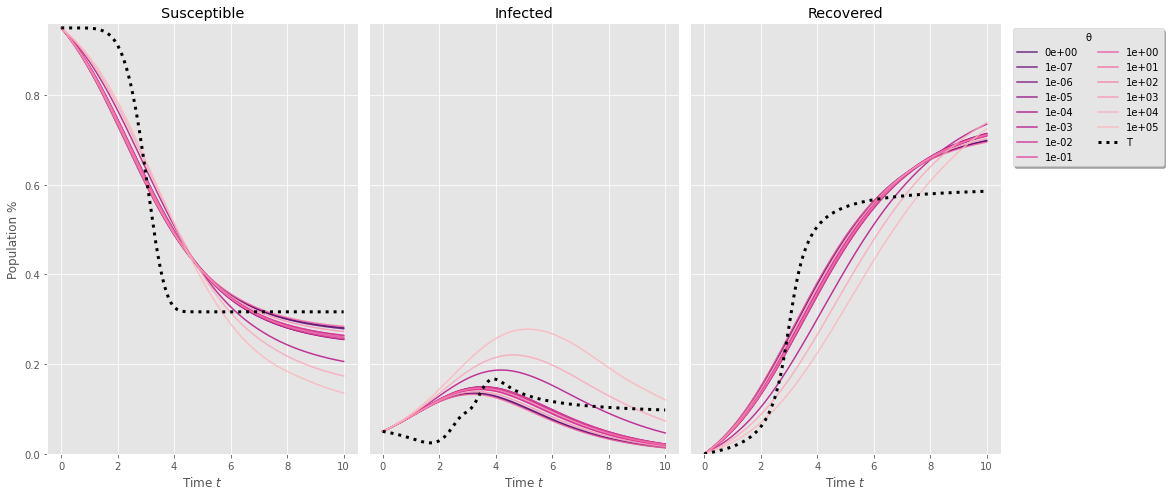

In [36]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Tests/Regularisation – States.pdf', bbox_inches='tight', pad_inches=0)

[]

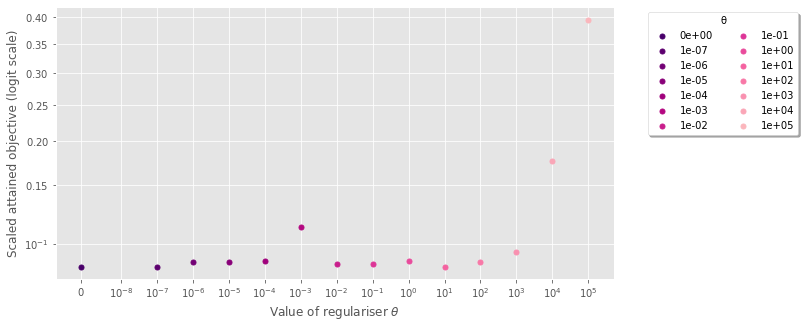

In [37]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh:

In [38]:
θ = 0.0

In [39]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [40]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.09590670201662092; (β,γ): 0.006666666666666667 0.706


Plot of objective evaluations for f(α)/n² over finer grid


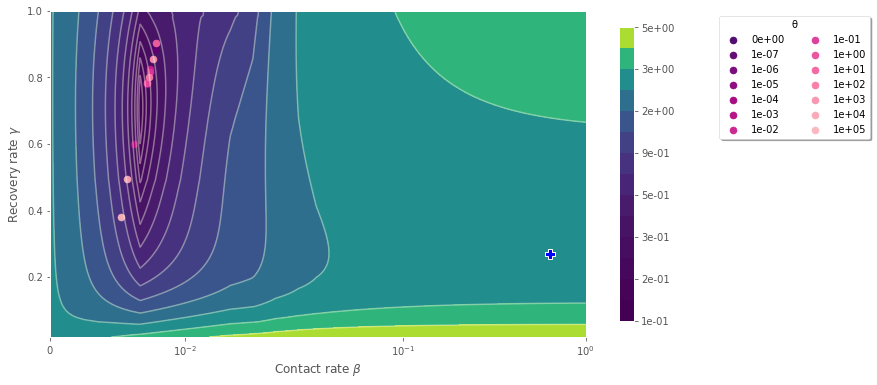

In [41]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )

# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.95, marker='.', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)



'''
# Optimisation path PGD
ℓ_PGD = 1660
plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = 'gold',
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ ℓ_PGD:], γ_PGD[ ℓ_PGD:], c='gold', alpha=0.01, marker='3', linestyle = ':', markersize='4')

# Optimisation path FISTA
ℓ_FISTA = 20
plt.plot( β_FISTA[:ℓ_FISTA], γ_FISTA[:ℓ_FISTA], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( β_FISTA[ ℓ_FISTA-1:], γ_FISTA[ ℓ_FISTA-1:], c='r', markeredgecolor = 'xkcd:rosa',
         alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
plt.plot( β_LM, γ_LM, c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='d', linestyle = '-.', markersize=4, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )
'''


ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
fig.savefig('Tests/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around minimisers:

In [42]:
θ = 0.0

In [43]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,0.01,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [44]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.08483374432970263; (β,γ): 0.0078000000000000005 0.8954666666666666


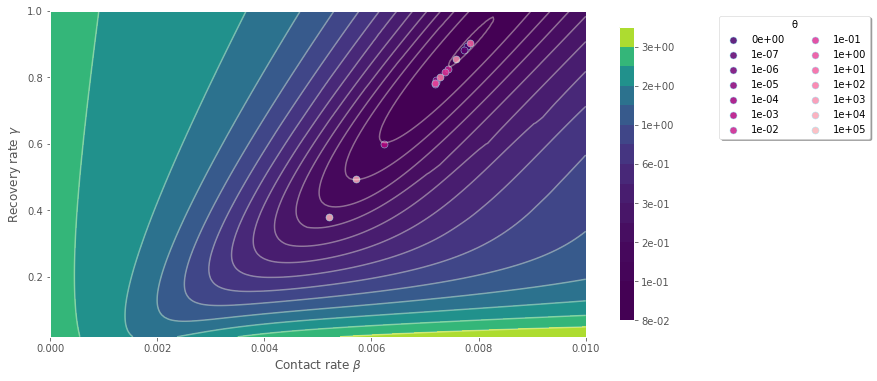

In [45]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min


# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row], edgecolor = "xkcd:robin's egg blue",
         alpha =0.85, marker='.', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)

'''# Optimisation path PGD
ℓ_PGD = 21
h_PGD = 33
plt.plot( clip(β_PGD[ ℓ_PGD:h_PGD],0.02,0.032), clip(γ_PGD[ ℓ_PGD:h_PGD],0.5, 0.7), 
            c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ h_PGD-1:], γ_PGD[ h_PGD-1:], c='gold', alpha=0.7, marker='3', linestyle = '-', 
         markersize=0.1, linewidth=0.05)


# Optimisation path FISTA
ℓ_FISTA = 30
h_FISTA = 40
plt.plot( β_FISTA[ℓ_FISTA:h_FISTA], γ_FISTA[ℓ_FISTA:h_FISTA], c='r', 
             markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa', linewidth=3,
                 alpha=0.75, marker='.', linestyle = '-', markersize='3', label='FISTA')
plt.plot( β_FISTA[ h_FISTA:], γ_FISTA[ h_FISTA:], c='r', markeredgecolor = 'xkcd:rosa', linewidth=2,
             alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
ℓ_LM = 18
plt.plot( clip(β_LM[ℓ_LM:],0.02,0.032), clip(γ_LM[ℓ_LM:],0.5, 0.7), c='xkcd:turquoise blue', 
             markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', linewidth=2.3,
                 alpha=0.9, marker='d', linestyle = '-.', markersize=5, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )'''





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Tests/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

---

In [46]:
Stats

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,3128,0.084842,16.669936,0.007788,0.892901,0.059648,-0.003859,0.031754,0.042266,0.059648,0.003859
1.000000e-07,4672,0.084903,22.923078,0.007732,0.882813,0.110168,-0.008054,0.059111,0.078108,0.110168,0.008054
1.000000e-06,9999,0.088022,47.172081,0.007212,0.785478,2.156255,-0.068648,1.112452,1.525475,2.156255,0.068648
1.000000e-05,8061,0.087783,35.875959,0.007205,0.790228,-3.715067,-0.034291,1.874679,2.627061,3.715067,0.034291
1.000000e-04,5704,0.088325,29.744229,0.007177,0.780278,0.880495,-0.065258,0.472877,0.624311,0.880495,0.065258
1.000000e-03,9489,0.112265,37.076473,0.006228,0.598870,1.422637,-0.235195,0.828916,1.019611,1.422637,0.235195
1.000000e-02,9999,0.086217,42.389331,0.007423,0.823805,2.642140,-0.049825,1.345982,1.868607,2.642140,0.049825
1.000000e-01,9999,0.086473,42.825436,0.007376,0.816773,1.040048,-0.045338,0.542693,0.736123,1.040048,0.045338
1.000000e+00,7526,0.088225,33.548139,0.007178,0.782033,-0.602588,-0.055479,0.329033,0.427896,0.602588,0.055479
1.000000e+01,4635,0.084931,21.519922,0.007840,0.903618,-1.161688,0.007256,0.584472,0.821453,1.161688,0.007256


In [47]:
Stats.to_pickle('Tests/Regularisation – FISTA - Final.pkl') # To read back use pd.read_pickle(file_name)

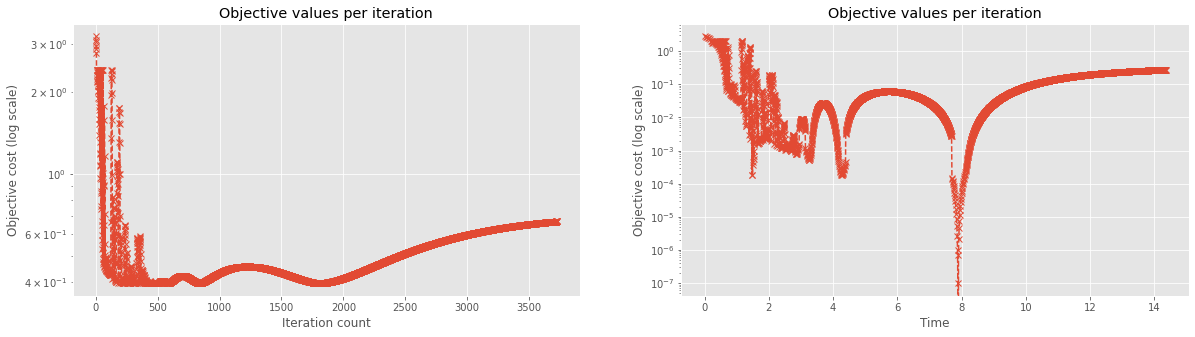

In [48]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'],'x--' )#- min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), 'x--')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

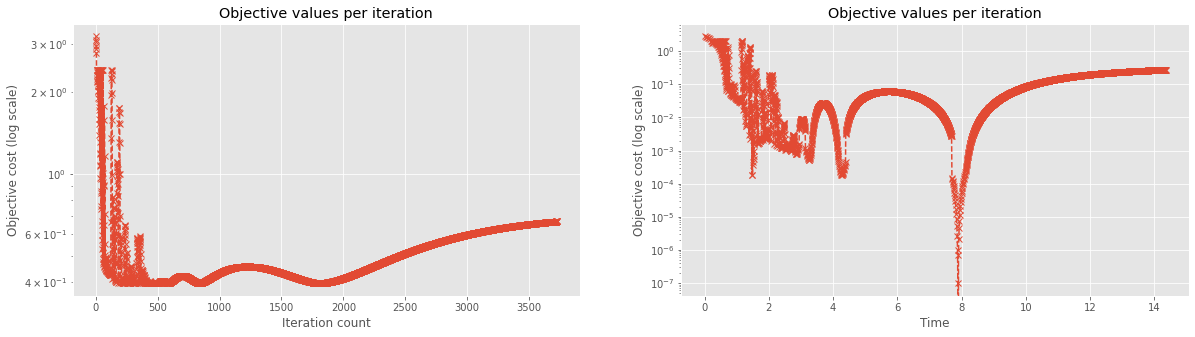

In [49]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'],'x--' )#- min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), 'x--')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [50]:
df_critical = pd.DataFrame.from_dict(every_critical)
#df_critical.to_pickle(out_folder+'Exact_Critical_Exact.pkl') # To read back use pd.read_pickle(file_name)
#df_critical.to_excel(out_folder+'Critical.xlsx')
#display(df_critical)

# If we want this table in LaTeX format run:
#print(df_critical.to_latex(index=False))

In [51]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
#Stats.to_pickle('Tests/Regularisation – FISTA - Best.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
3722,3721,0.667941,14.342348,0.003764,0.37888,-446.243524,2.142243,224.192883,315.545458,446.243524,2.142243
3723,3722,0.668001,14.345251,0.003763,0.37888,-446.735342,2.138656,224.436999,315.893210,446.735342,2.138656
3724,3723,0.668061,14.348391,0.003763,0.37888,-445.719963,2.134403,223.927183,315.175222,445.719963,2.134403
3725,3724,0.668120,14.351281,0.003763,0.37888,-445.464264,2.129983,223.797123,314.994403,445.464264,2.129983
3726,3725,0.668179,14.354170,0.003763,0.37888,-445.116396,2.129172,223.622784,314.748423,445.116396,2.129172


In [52]:
ArgMin_FISTA = df_every.idxmin()['obj']        # Identify iterate that had showcased smallest objective

In [438]:
df_every.loc[[ArgMin_FISTA]].rename(index={ArgMin_FISTA:θ}).copy()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.0,4999,0.084825,24.576566,0.007824,0.89963,-0.014225,0.000291,0.007258,0.010061,0.014225,0.000291


In [449]:
pd.DataFrame(df_every.loc[df_every.idxmin()['obj']]).T
#.rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
5000,4999.0,0.111817,22.578484,0.006235,0.600879,0.832968,-0.229533,0.53125,0.61095,0.832968,0.229533


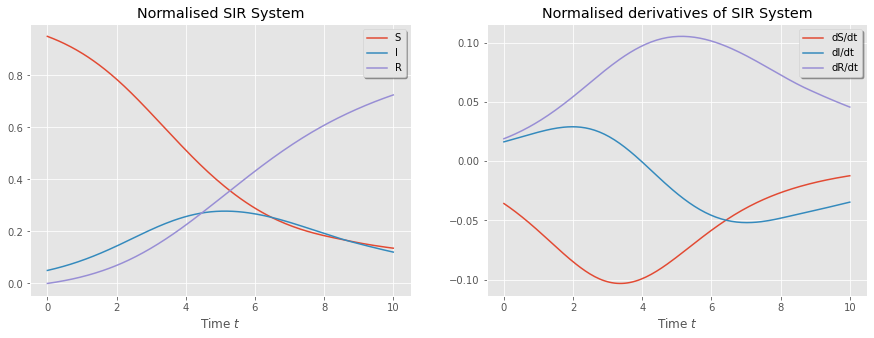

In [53]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, ᾱ[0], ᾱ[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

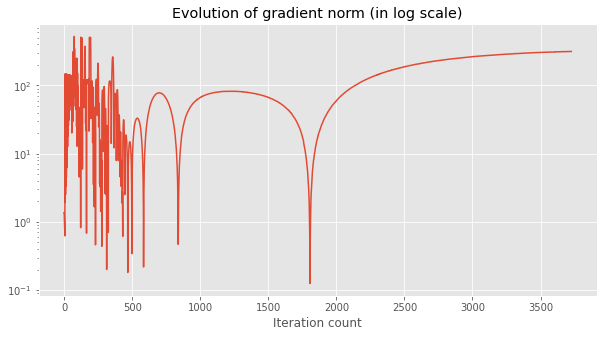

In [54]:
# Evolution of gradient norm
plt.figure(figsize=(10,5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
#plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

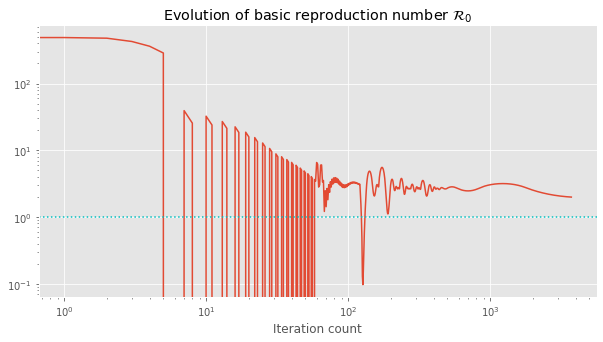

In [55]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

In [56]:
α̂ = df_every['β'][ argmin(df_every['obj']) ], df_every['γ'][ argmin(df_every['obj']) ]

β_its, γ_its = maximum(df_every['β'].to_numpy(), 0.0071), df_every['γ'].to_numpy()

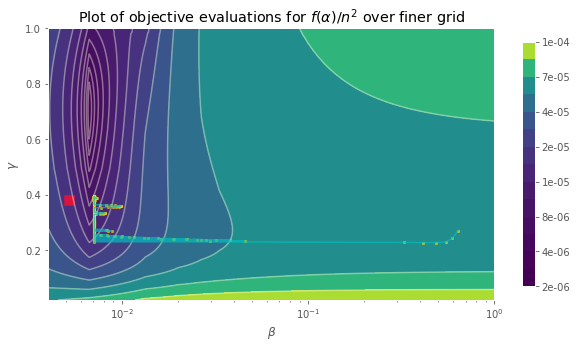

In [60]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

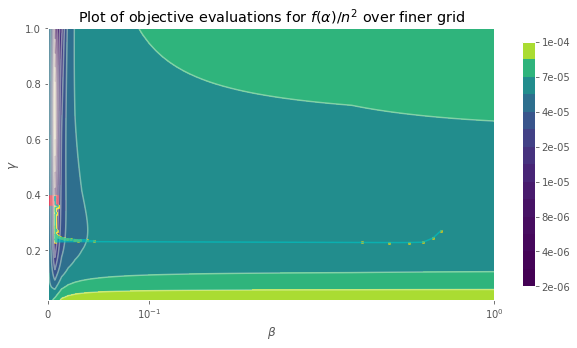

In [61]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
plt.xscale('symlog', linthresh = 3e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

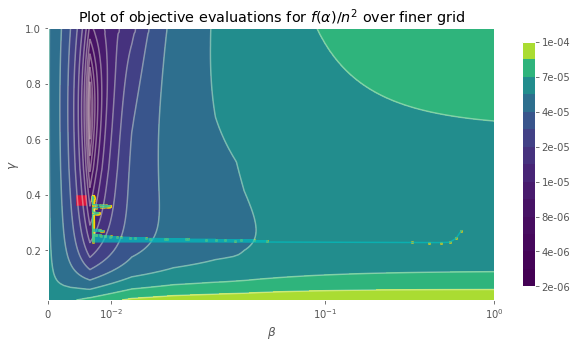

In [62]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
plt.xscale('symlog', linthresh = 3e-2)
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

---